# NEURAL NETWORK with K-MEANS for MNIST

#### Import

In [128]:
import sys
import time
import pickle
import gzip
from random import randint
from scipy import misc
from scipy import special
import scipy.ndimage
import numpy as np
import datetime as dt
from sklearn.cluster import KMeans,MiniBatchKMeans
import matplotlib.pyplot as plt
import json
import collections
import math

#### Initial Settings

In [3]:
DATA_PATH = 'data/mnist/'

IMAGES_TRAIN = 'data_training'
IMAGES_TEST = 'data_testing'

RANDOM_SEED = 42
N_CLASSES = 10
N_FEATURES = 28 * 28

In [4]:
data_training = DATA_PATH+IMAGES_TRAIN
data_testing = DATA_PATH+IMAGES_TEST
ft = gzip.open(data_training, 'rb')
TRAINING = pickle.load(ft)
ft.close()
ft = gzip.open(data_testing, 'rb')
TESTING = pickle.load(ft)
ft.close()

## Neural Network

In [192]:
class Neural_Network:

    # Stop function
    # 0 : Fixed (stop after n epochs)
    # 1 : Progress (stop after n epochs w/o improvements)
    # 2 : Std Dev (stop after an improvements below n)
    
    def __init__(self, neurons, batchsize, stop_function, stop_parameter):
        self.input_size = N_FEATURES
        self.output_size = N_CLASSES
        self.neurons = neurons
        self.batchsize = batchsize
        self.stop_f = stop_function
        self.stop_p = stop_parameter
        self.best = 0.
        self.same = 0
        
        # Standardize random weights
        np.random.seed(RANDOM_SEED)
        hidden_layer = np.random.rand(self.neurons, self.input_size + 1) / self.neurons
        output_layer = np.random.rand(self.output_size, self.neurons + 1) / self.output_size
        self.layers = [hidden_layer, output_layer]
        self.iteration = 0

    def train(self, training, testing):
        
        accu = [0.,0.]
        
        # Batch Setting
        len_batch_train = len(training[0])
        len_batch_test = len(testing[0])
        if(self.batchsize > 0 and self.batchsize <= 1):
            len_batch_train = int(np.ceil(len_batch_train * self.batchsize))
            len_batch_test = int(np.ceil(len_batch_test * self.batchsize))
        
        # Start prints 
        self.start_time = dt.datetime.now()
        print('-- Training Session Start (%s) --' % (self.start_time))
        typeTrainingPrint = "Stop Function: "    
        if self.stop_f == 0:
            typeTrainingPrint += str(self.stop_p)+" epochs"
        elif self.stop_f == 1:
            typeTrainingPrint += str(self.stop_p)+" epoch(s) w/o improvements"
        elif self.stop_f == 2:
            typeTrainingPrint += "improvements below "+str(self.stop_p)+"%"
        print('\nNeurons: %d\nBatch Train: %d\nBatch Test: %d\n%s\n' % (self.neurons,len_batch_train,len_batch_test,typeTrainingPrint))
        
        # Divide training and testing batches
        test_output = testing[0:len_batch_test][0:len_batch_test]
        inputs = training[0][0:len_batch_train]
        targets = np.zeros((len_batch_train, 10))
        for i in range(len_batch_train):
            targets[i, training[1][i]] = 1

        # Performs iterations
        while not self.is_stop_function_enabled(accu[1]):
            for input_vector, target_vector in zip(inputs, targets):
                self.backpropagate(input_vector, target_vector)
            
            # Accuracy
            accu = self.accu(test_output)
            self.iteration += 1
            
            # Messages
            if (self.iteration == 1 or self.iteration % 10 == 0):
                self.print_message_iter(self.iteration,accu,self.ETAepoch(self.start_time))
                
        # Print last epoch
        if (self.iteration % 10 != 0):
            self.print_message_iter(self.iteration,accu,self.ETAepoch(self.start_time))

        # Final message
        print('\n-- Training Session End (%s) --' % (dt.datetime.now()))

    def feed_forward(self, input_vector):
        outputs = []
        for layer in self.layers:
            input_with_bias = np.append(input_vector, 1)   # Ajout constante
            output = np.inner(layer, input_with_bias)
            output = special.expit(output)
            outputs.append(output)
            # The output is the input of the next layer
            input_vector = output
        return outputs

    def backpropagate(self, input_vector, target):
        c = 1./math.sqrt(self.iteration + 10)  # Learning coefficient
        hidden_outputs, outputs = self.feed_forward(input_vector)

        # Calculation of partial derivatives for the output layer and subtraction
        output_deltas = outputs * (1 - outputs) * (outputs - target)
        self.layers[-1] -= c*np.outer(output_deltas, np.append(hidden_outputs, 1))

        # Calculation of partial derivatives for the hidden layer and subtraction
        hidden_deltas = hidden_outputs * (1 - hidden_outputs) * np.dot(np.delete(self.layers[-1], 200, 1).T, output_deltas)
        self.layers[0] -= c*np.outer(hidden_deltas, np.append(input_vector, 1))

    def predict(self, input_vector):
        return self.feed_forward(input_vector)[-1]

    def predict_one(self, input_vector):
        return np.argmax(self.feed_forward(input_vector)[-1])

    def accu(self, testing):
        res = np.zeros((10, 2))
        for k in range(len(testing[1])):
            if self.predict_one(testing[0][k]) == testing[1][k]:
                res[testing[1][k]] += 1
            else:
                res[testing[1][k]][1] += 1
        total = np.sum(res, axis=0)
        each = [res[k][0]/res[k][1] for k in range(len(res))]
        min_c = sorted(range(len(each)), key=lambda k: each[k])[0]
        return np.round([each[min_c]*100, total[0]/total[1]*100, min_c], 2)
    
    def is_stop_function_enabled(self,accuracy):
        if self.stop_f == 0:
            if self.iteration < self.stop_p:
                return False
            else:
                return True
        elif self.stop_f == 1:
            if accuracy > self.best or self.iteration == 0:
                self.same = 0
                self.best = accuracy
                return False
            else:
                self.same += 1
                if self.same < self.stop_p:
                    return False
                else:
                    return True
        elif self.stop_f == 2:
            if accuracy > self.best + self.stop_p or self.iteration == 0:
                self.best = accuracy
                return False
            else:
                return True
    
    def print_message_iter(self,iteration,accu,eta):
        len_eta = len(eta)
        space_fill = 6 - len_eta
        eta = "("+eta+")"
        for _ in range(space_fill):
            eta += " "
        message = 'Epoch '+str(self.iteration).zfill(3) + " "+eta+" "
        message += 'Accuracy: '+str(accu[1]).zfill(4)+'%\tMin: '+ str(accu[0]).zfill(4)+ '% ('+str(int(accu[2]))+')'
        print(message)
    
    def ETAepoch(self,start_time):
        diff = dt.datetime.now() - self.start_time
        eta = divmod(diff.days * 86400 + diff.seconds, 60)
        if eta[0] != 0:
            ret = str(eta[0])+"m"
        else:
            ret = ""
        ret += str(eta[1])+"s"
        return ret
        
    def getWeights(self):
        return self.layers

In [193]:
nn = Neural_Network(neurons=300,batchsize=0.1,stop_function=1,stop_parameter=4)
nn.train(TRAINING,TESTING)

-- Training Session Start (2018-10-17 18:10:20.489968) --

Neurons: 300
Batch Train: 6000
Batch Test: 1000
Stop Function: 4 epoch(s) w/o improvements

Epoch 001 (4s)     Accuracy: 47.75%	Min: 00.0% (2)
Epoch 010 (44s)    Accuracy: 91.81%	Min: 80.94% (5)
Epoch 020 (1m27s)  Accuracy: 92.4%	Min: 82.03% (8)
Epoch 027 (1m57s)  Accuracy: 93.22%	Min: 88.79% (5)

-- Training Session End (2018-10-17 18:12:18.002730) --


## K-MEANS

#### Find nearest centroid given a value

In [158]:
def nearest_centroid_index(centers,value):
    centers = np.asarray(centers)
    idx = (np.abs(centers - value)).argmin()
    return idx

def nearest_centroid(centers,value):
    centers = np.asarray(centers)
    idx = (np.abs(centers - value)).argmin()
    return centers[idx]

#### Building clusters with pre trained weights

In [159]:
nn_weights = nn.getWeights()

def reshape_weights_for_kmeans(weights):
    return np.hstack(weights).reshape(-1,1)

def build_clusters(cluster,weights):
    kmeans = MiniBatchKMeans(n_clusters=cluster,random_state=RANDOM_SEED)
    kmeans.fit(reshape_weights_for_kmeans(weights))
    return {k:v[0] for k,v in enumerate(kmeans.cluster_centers_)}

build_clusters(10,nn_weights[0])

{0: -0.0807723365637731,
 1: 0.0030092386354939817,
 2: 0.09926220110067807,
 3: 0.5176137778670392,
 4: -0.33514236687509735,
 5: 0.3219722720677812,
 6: -0.18941163326264426,
 7: -0.4888695284396932,
 8: 0.04637445574379022,
 9: 0.18494851254956435}

#### Redifine weights matrix for pre train

In [160]:
def redefine_weights(weights,centers):
        arr_ret = np.empty_like(weights)
        for i, row in enumerate(weights):
            for j, col in enumerate(row):
                arr_ret[i,j] = nearest_centroid_index(centers,weights[i,j])
        return arr_ret

#### Mean of distance between elements in centroid

In [161]:
def mean_distance(weights,centroids):
    tot = 0.
    for i, row in enumerate(weights):
        for j, col in enumerate(row):
            weight = weights[i,j]
            centroid = nearest_centroid(centroids,weight)[0]
            tot += np.sqrt((weight - centroid)**2)
    return tot / ((i+1)*(j+1))

#### Mean with different clusters number

In [162]:
def find_clusters_number(values,n_from,n_to,n_jump):
    start_time = dt.datetime.now()
    RANDOM_SEED = 42
    result = {}
    for i in range(n_from,n_to+1,n_jump):
        kmeans = MiniBatchKMeans(n_clusters=i,random_state=RANDOM_SEED)
        kmeans.fit(reshape_weights_for_kmeans(values))
        mean = mean_distance(values,kmeans.cluster_centers_)
        result[i] = mean
        print("Mean for %s clusters %f (%s) " % (str(i).zfill(3),mean,eta_from_start(start_time)))
    return result

def eta_from_start(start_time):
    diff = dt.datetime.now() - start_time
    eta = divmod(diff.days * 86400 + diff.seconds, 60)
    return str(eta[0])+"m"+str(eta[1])+"s"
        
means_cluster_1_10 = find_clusters_number(nn_weights[0],1,101,10)

Mean for 001 clusters 0.052564 (0m1s) 
Mean for 011 clusters 0.010691 (0m3s) 
Mean for 021 clusters 0.005886 (0m4s) 
Mean for 031 clusters 0.004236 (0m6s) 
Mean for 041 clusters 0.003233 (0m7s) 
Mean for 051 clusters 0.002900 (0m9s) 
Mean for 061 clusters 0.002431 (0m11s) 
Mean for 071 clusters 0.002411 (0m12s) 
Mean for 081 clusters 0.001846 (0m17s) 
Mean for 091 clusters 0.001732 (0m19s) 
Mean for 101 clusters 0.001684 (0m20s) 


#### Redefine matrix (index --> centroid)

In [163]:
def values_from_dict(a,d):
    new_array = np.copy(a)
    for k, v in d.items():
        new_array[a==k] = v
    return new_array

#### Calculate gradient for each cluster centroid

In [164]:
def centroid_gradient(idx_matrix,gradient,cluster):
    return scipy.ndimage.sum(gradient,idx_matrix,index=range(cluster))

#### Reading from JSON

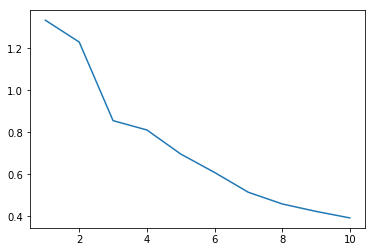

In [165]:
def get_data_from_json(file):
    with open(file) as f:
        return json.load(f)
    
def get_list_values_from_json(data,field,variable):
    return [element[field] for element in data[variable]]

data = get_data_from_json('log/Log_Cluster_Setting_Mean.json')
x = get_list_values_from_json(data,"cluster","cluster_mean")
y = get_list_values_from_json(data,"mean","cluster_mean")

plt.plot(x[:10],y[:10])
plt.show()

## Dictionary

In [166]:
cluster_number = 500
centers = build_clusters(cluster_number,nn_weights[0])

/Users/Moris/anaconda3/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:1418: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)


In [167]:
# map (i,j) -> k
def dict_index_to_cluster(weights,centers):
        dict_ret = {}
        for i, row in enumerate(weights):
            for j, col in enumerate(row):
                dict_ret[(i,j)] = nearest_centroid_index([x for x in centers.values()],weights[i,j])
        return dict_ret

dict_index = dict_index_to_cluster(nn_weights[0],centers)

In [168]:
# map k -> (i,j)
def dict_cluster_to_index(dict_idx):
    dict_ret = {}
    for k,v in dict_idx.items():
        if v in dict_ret:
            dict_ret[v] += [k]
        else:
            dict_ret[v] = [k]
    return dict_ret

dict_cluster = dict_cluster_to_index(dict_index)

In [169]:
# helper function
def getCluster(d,v):
    return d[v]

def getIndices(d,k):
    return d[k]

getCluster(dict_index,(7,42))
getIndices(dict_cluster,106)[0:10]

[(1, 125),
 (1, 360),
 (3, 215),
 (3, 244),
 (3, 381),
 (3, 463),
 (3, 604),
 (3, 627),
 (6, 404),
 (10, 653)]

In [170]:
# from dict (k -> (i,j)) to matrix with centers
def dict_to_matrix(dict_index,dict_values,shape):
    coord_array = np.asarray(list(dict_index.values()))
    values_array = np.asarray(list(dict_values.values()))
    return values_array[coord_array].reshape(shape)

dict_to_matrix(dict_index,centers,(300,785))

array([[1.26862951e-03, 3.19190317e-03, 2.40046357e-03, ...,
        8.20254009e-04, 1.20530890e-03, 1.08050035e-01],
       [3.02574309e-03, 1.94675457e-03, 1.34426981e-03, ...,
        2.65178764e-04, 2.04258203e-03, 6.86333198e-02],
       [1.95085347e-03, 6.05894593e-04, 2.40046357e-03, ...,
        2.04258203e-03, 2.92502098e-03, 4.88773534e-01],
       ...,
       [1.74872440e-03, 2.40046357e-03, 1.60996216e-03, ...,
        3.02574309e-03, 1.06417056e-03, 1.39778088e-01],
       [3.11801924e-03, 7.41992452e-05, 1.95085347e-03, ...,
        3.27692829e-03, 4.95935282e-04, 1.88471897e-01],
       [3.04695558e-03, 7.41992452e-05, 1.20530890e-03, ...,
        1.80728862e-03, 3.11801924e-03, 2.48428515e-01]])

In [171]:
# old function with index matrix
idx_mat = redefine_weights(nn_weights[0],[v for v in centers.values()])
values_from_dict(idx_mat,centers)

array([[1.26862951e-03, 3.19190317e-03, 2.40046357e-03, ...,
        8.20254009e-04, 1.20530890e-03, 1.08050035e-01],
       [3.02574309e-03, 1.94675457e-03, 1.34426981e-03, ...,
        2.65178764e-04, 2.04258203e-03, 6.86333198e-02],
       [1.95085347e-03, 6.05894593e-04, 2.40046357e-03, ...,
        2.04258203e-03, 2.92502098e-03, 4.88773534e-01],
       ...,
       [1.74872440e-03, 2.40046357e-03, 1.60996216e-03, ...,
        3.02574309e-03, 1.06417056e-03, 1.39778088e-01],
       [3.11801924e-03, 7.41992452e-05, 1.95085347e-03, ...,
        3.27692829e-03, 4.95935282e-04, 1.88471897e-01],
       [3.04695558e-03, 7.41992452e-05, 1.20530890e-03, ...,
        1.80728862e-03, 3.11801924e-03, 2.48428515e-01]])

In [172]:
%timeit values_from_dict(idx_mat,centers)
%timeit dict_to_matrix(dict_index,centers,(300,785))

52.3 ms ± 1.39 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
17 ms ± 560 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [173]:
%timeit centroid_gradient(idx_mat,nn_weights[0],cluster_number)

16.9 ms ± 70.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [174]:
def cg_4(K_Index,W_Matrix):
    tmpindex = dict((key, ([x for x, _ in value], [y for _, y in value])) for key, value in K_Index.items())
    return [W_Matrix[value[0],value[1]].sum() for value in tmpindex.values()]

%timeit cg_4(dict_cluster,nn_weights[0])

84.5 ms ± 437 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [175]:
def dict_to_index_matrix(dict_cluster):
    arr_ret = np.zeros((300,785))
    for k,v in dict_cluster.items():
        for i in v:
            arr_ret[i] = k
    return arr_ret

%timeit idx_matrix = dict_to_index_matrix(dict_cluster)

51.5 ms ± 717 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Neural Network with K-Means

In [186]:
class Neural_Network_KM:

    def __init__(self, neurons, batchsize, cluster, pre_weights, verbose, stop_function, stop_parameter):
        
        start_setting_time = dt.datetime.now()
        
        self.input_size = N_FEATURES
        self.output_size = N_CLASSES
        self.neurons = neurons
        self.batchsize = batchsize
        self.verbose = verbose
        self.cluster = cluster
        self.iteration = 0
        self.stop_f = stop_function
        self.stop_p = stop_parameter
        self.best = 0.
        self.same = 0
        
        # Variable for shape
        shape_hidden = (self.neurons,self.input_size+1)
        shape_output = (self.output_size,self.neurons+1)
        self.layers_shape = [shape_hidden,shape_output]
            
        # Initialize cluster for pre-trained weights (dict with centers)
        c_hidden = build_clusters(self.cluster,pre_weights[0])
        c_output = build_clusters(self.cluster,pre_weights[-1])
        self.centers = [c_hidden,c_output]
        
        # Initialize index matrix for pre-trained weights
        idx_hidden = redefine_weights(pre_weights[0],list(c_hidden.values()))
        idx_output = redefine_weights(pre_weights[-1],list(c_output.values()))
        self.idx_layers = [idx_hidden,idx_output]
        
        # Initialize dict [map (i,j) -> k]
        dict_hidden = dict_index_to_cluster(pre_weights[0],self.centers[0])
        dict_output = dict_index_to_cluster(pre_weights[-1],self.centers[-1])
        self.dict = [dict_hidden,dict_output]
        
        # Setting time print    
        end_setting_time = dt.datetime.now() - start_setting_time
        eta = divmod(end_setting_time.days * 86400 + end_setting_time.seconds, 60)
        self.eta_print_setting = str(eta[0])+"m"+str(eta[1])+"s"
        if self.verbose:
            print("--- Setting Time: %s ---" % self.eta_print_setting)
    
 

    def train(self, training, testing):
        
        accu = [0.,0.]
        
        # Batch Setting
        len_batch_train = len(training[0])
        len_batch_test = len(testing[0])
        if(self.batchsize > 0 and self.batchsize <= 1):
            len_batch_train = int(np.ceil(len_batch_train * self.batchsize))
            len_batch_test = int(np.ceil(len_batch_test * self.batchsize))
        
        # Divide training and testing batches
        test_output = testing[0:len_batch_test][0:len_batch_test]
        inputs = training[0][0:len_batch_train]
        targets = np.zeros((len_batch_train, 10))
        for i in range(len_batch_train):
            targets[i, training[1][i]] = 1
        
        # Start prints 
        self.start_time = dt.datetime.now()
        print('-- Training Session Start (%s) --' % (self.start_time))
        typeTrainingPrint = "Stop Function: "    
        if self.stop_f == 0:
            typeTrainingPrint += str(self.stop_p)+" epochs"
        elif self.stop_f == 1:
            typeTrainingPrint += str(self.stop_p)+" epoch(s) w/o improvements"
        elif self.stop_f == 2:
            typeTrainingPrint += "improvements below "+str(self.stop_p)+"%"
        print('\nNeurons: %d\nBatch Train: %d\nBatch Test: %d\n%s\n' % (self.neurons,len_batch_train,len_batch_test,typeTrainingPrint))
        
        # Performs iterations
        while not self.is_stop_function_enabled(accu[1]):
            
            # Backpropagate with feed forward
            for input_vector, target_vector in zip(inputs, targets):
                # from index matrix to weights matrix with centroid
                weights = []
                for d,c,s in zip(self.dict,self.centers,self.layers_shape):
                    w = dict_to_matrix(d,c,s)
                    #w = values_from_dict(idxm,c)
                    weights.append(w)
                self.backpropagate(input_vector, target_vector, weights)
                
            # Accuracy
            accu = self.accu(test_output,weights)
            self.iteration += 1
            
            # Messages
            #if (self.iteration == 1 or self.iteration % 10 == 0):
            self.print_message_iter(self.iteration,accu,self.ETAepoch(self.start_time))
                      
        # Print last epoch result
        if self.iteration % 10 != 0:
            self.print_message_iter(self.iteration,accu,self.ETAepoch(self.start_time))

        # Final message
        print('\n-- Training Session End (%s) --' % (dt.datetime.now()))

    def feed_forward(self, input_vector, weights):
        outputs = []
        for w in weights:
            input_with_bias = np.append(input_vector, 1)   # Ajout constante
            output = np.inner(w, input_with_bias)
            output = special.expit(output) # Sigmoid function
            outputs.append(output)
            # The output is the input of the next layer
            input_vector = output
        return outputs

    def backpropagate(self, input_vector, target, weights):
        c = 0.1/math.sqrt(self.iteration + 10)  # Learning coefficient
        hidden_outputs, outputs = self.feed_forward(input_vector, weights)

        # Calculation of partial derivatives for the output layer and subtraction
        output_deltas = outputs * (1 - outputs) * (outputs - target)
        gradient = np.outer(output_deltas, np.append(hidden_outputs, 1))
        cg = centroid_gradient(self.idx_layers[-1],gradient,self.cluster)
        self.centers[-1] = {x: self.centers[-1][x]-(c*cg[x]) for x in self.centers[-1]}

        # Calculation of partial derivatives for the hidden layer and subtraction
        hidden_deltas = hidden_outputs * (1 - hidden_outputs) * np.dot(np.delete(weights[-1], 200, 1).T, output_deltas)
        gradient = np.outer(hidden_deltas, np.append(input_vector, 1))
        cg = centroid_gradient(self.idx_layers[0],gradient,self.cluster)
        self.centers[0] = {x: self.centers[0][x]-(c*cg[x]) for x in self.centers[0]}
        
    
    
    def predict(self, input_vector, weights):
        return self.feed_forward(input_vector,weights)[-1]

    def predict_one(self, input_vector, weights):
        return np.argmax(self.feed_forward(input_vector,weights)[-1])

    def accu(self, testing, weights):
        res = np.zeros((10, 2))
        for k in range(len(testing[1])):
            if self.predict_one(testing[0][k], weights) == testing[1][k]:
                res[testing[1][k]] += 1
            else:
                res[testing[1][k]][1] += 1
        total = np.sum(res, axis=0)
        each = [res[k][0]/res[k][1] for k in range(len(res))]
        min_c = sorted(range(len(each)), key=lambda k: each[k])[0]
        return np.round([each[min_c]*100, total[0]/total[1]*100, min_c], 2)
    
    
    def is_stop_function_enabled(self,accuracy):
        if self.stop_f == 0:
            if self.iteration < self.stop_p:
                return False
            else:
                return True
        elif self.stop_f == 1:
            if accuracy > self.best or self.iteration == 0:
                self.same = 0
                self.best = accuracy
                return False
            else:
                self.same += 1
                if self.same < self.stop_p:
                    return False
                else:
                    return True
        elif self.stop_f == 2:
            if accuracy > self.best + self.stop_p or self.iteration == 0:
                self.best = accuracy
                return False
            else:
                return True
    
    def print_message_iter(self,iteration,accu,eta):
        len_eta = len(eta)
        space_fill = 6 - len_eta
        eta = "("+eta+")"
        for _ in range(space_fill):
            eta += " "
        message = 'Epoch '+str(self.iteration).zfill(3) + " "+eta+" "
        message += 'Accuracy: '+str(accu[1]).zfill(4)+'%\tMin: '+ str(accu[0]).zfill(4)+ '% ('+str(int(accu[2]))+')'
        print(message)
        
    def getWeights(self):
        return self.layers
    
    def minsec2sec(self,time):
        if 'm' in time:
            splitted = time.split('m')
            return int(splitted[0]) * 60 + int(splitted[1][:-1])
        else:
            return int(time[:-1])
    
    def ETAepoch(self,start_time):
        diff = dt.datetime.now() - self.start_time
        eta = divmod(diff.days * 86400 + diff.seconds, 60)
        if eta[0] != 0:
            ret = str(eta[0])+"m"
        else:
            ret = ""
        ret += str(eta[1])+"s"
        return ret
            

In [187]:
nn_km = Neural_Network_KM(neurons=300,batchsize=1,cluster=1000,pre_weights=nn_weights,verbose=True,stop_function=1,stop_parameter=2)
nn_km.train(TRAINING,TESTING)

/Users/Moris/anaconda3/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:1418: RuntimeWarning: init_size=300 should be larger than k=1000. Setting it to 3*k
  init_size=init_size)


--- Setting Time: 0m40s ---
-- Training Session Start (2018-10-16 13:51:06.430724) --

Neurons: 300
Batch Train: 60000
Batch Test: 10000
Stop Function: 2 epoch(s) w/o improvements

Epoch 001 (39m8s)  Accuracy: 93.57%	Min: 89.01% (5)
Epoch 002 (78m3s)  Accuracy: 93.67%	Min: 89.46% (5)
Epoch 003 (115m24s) Accuracy: 93.88%	Min: 89.8% (5)
Epoch 004 (154m13s) Accuracy: 93.92%	Min: 90.7% (5)
Epoch 005 (193m1s) Accuracy: 93.92%	Min: 91.59% (5)
Epoch 006 (231m51s) Accuracy: 94.01%	Min: 92.02% (7)
Epoch 007 (268m55s) Accuracy: 94.1%	Min: 92.17% (9)
Epoch 008 (305m50s) Accuracy: 94.13%	Min: 91.97% (9)
Epoch 009 (343m56s) Accuracy: 94.21%	Min: 91.67% (9)
Epoch 010 (381m3s) Accuracy: 94.26%	Min: 91.48% (9)
Epoch 011 (419m42s) Accuracy: 94.28%	Min: 91.38% (9)
Epoch 012 (458m45s) Accuracy: 94.27%	Min: 91.28% (9)
Epoch 013 (495m37s) Accuracy: 94.29%	Min: 91.08% (9)
Epoch 014 (532m10s) Accuracy: 94.32%	Min: 90.98% (9)
Epoch 015 (576m6s) Accuracy: 94.37%	Min: 90.88% (9)
Epoch 016 (614m2s) Accuracy: 94.